In [1]:
import pandas as pd
import seaborn as sns
import os,glob
import warnings
from matplotlib import rcParams
warnings.filterwarnings("ignore")

In [2]:
%load_ext rpy2.ipython

# Multiplex FISH----Data Analysis

In [6]:
%%R
library(Seurat)
library(tidyverse)
library(gtools)

In [4]:
%%R -o rawmatrix
rawmatrix=read.csv("gene_matrix.csv",row.names = 1)
rawmatrix=rawmatrix[,4:27]
dim(rawmatrix)

[1] 32460    24


In [5]:
%%R
rawscRNA<- CreateSeuratObject(counts = t(rawmatrix), min.cells = 1,project='RNAScope')
rawscRNA

An object of class Seurat 
24 features across 32460 samples within 1 assay 
Active assay: RNA (24 features, 0 variable features)


## 1-All cells (no filter, multiple batch) cluster analysis

不用normalize对数据进行标准化处理

In [ ]:
%%R
rawscRNA <- FindVariableFeatures(rawscRNA, selection.method = "vst",verbose=F)
all.genes <- rownames(rawscRNA)
rawscRNA <- ScaleData(rawscRNA, features = all.genes,verbose=F)
rawscRNA <- RunPCA(rawscRNA, features = VariableFeatures(object = rawscRNA),verbose=F)
rawscRNA <- JackStraw(rawscRNA, num.replicate = 100,verbose=F)
rawscRNA <- ScoreJackStraw(rawscRNA, dims = 1:20)


In [7]:
%%R
rawscRNA$batch=sapply(str_split(rownames(rawscRNA@meta.data),"_"),'[',1)
rawscRNA$section=sapply(str_split(rownames(rawscRNA@meta.data),"_"),'[',2)

In [8]:
%%R 
scRNA1 <- FindNeighbors(rawscRNA, dims = 1:20,verbose=F)%>%
          FindClusters(resolution = 0.4,verbose=F)%>%
          RunUMAP(dims = 1:20,verbose=F)%>%
          RunTSNE(dims = 1:20,verbose=F,check_duplicates = FALSE)

R[write to console]: Warning:
R[write to console]:  The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session



### 1) Plot: UMAP colored by 1) clusters: 2) section level:

Saving 16.7 x 8.33 in image


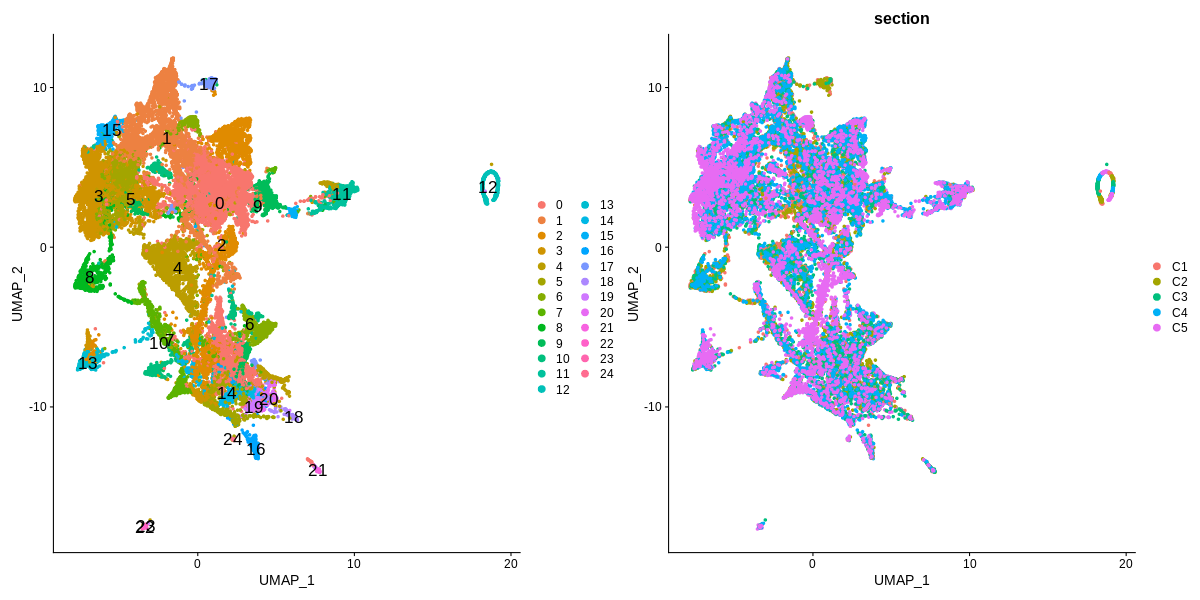

In [9]:
%%R -w 1200 -h 600
p1<-DimPlot(scRNA1, reduction = "umap",label = T,label.size = 6,pt.size = 1)
p2<-DimPlot(scRNA1, reduction = "umap",label = F,label.size = 6,pt.size = 1,group.by="section")
p=p1|p2

ggsave("allcell.cluster.pdf")
p

### 2) Plot: UMAP colored by Batches, showing repeatability between batches

In [13]:
%%R
scRNA1$group=paste(scRNA1$batch,scRNA1$section,sep='_')

Saving 16.7 x 8.33 in image


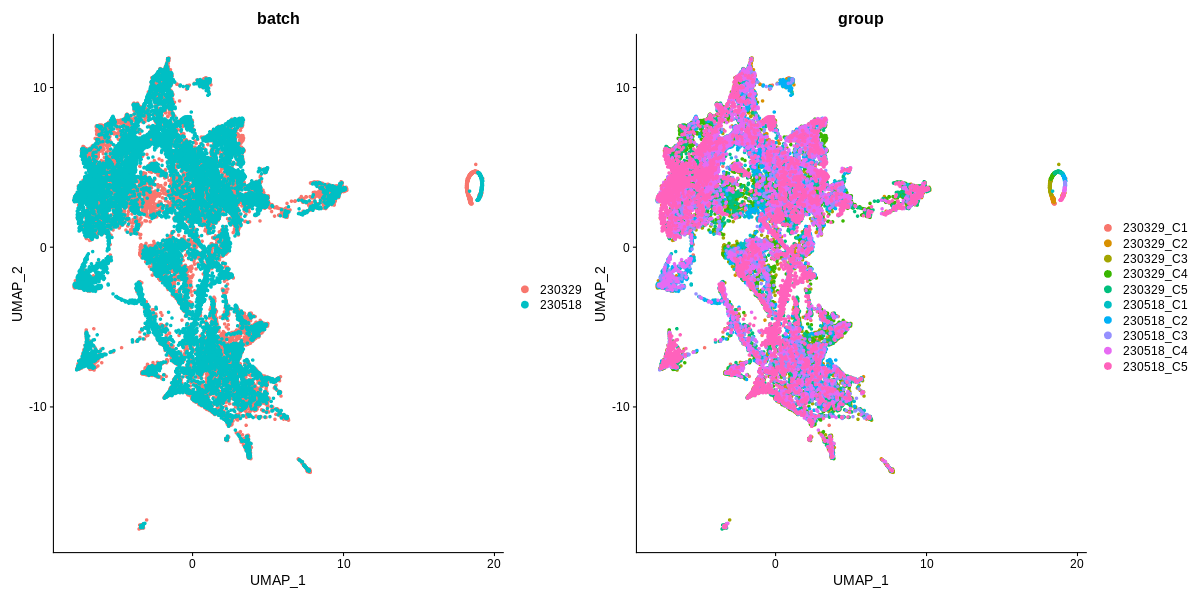

In [14]:
%%R -w 1200 -h 600
p1<-DimPlot(scRNA1, reduction = "umap",label = F,label.size = 6,pt.size = 1,group.by="batch")
p2<-DimPlot(scRNA1, reduction = "umap",label = F,label.size = 6,pt.size = 1,group.by="group")
p=p1|p2
ggsave("allcell.cluster.2.pdf")
p

In [15]:
%%R
table(scRNA1@meta.data[,c("seurat_clusters",'batch')])

               batch
seurat_clusters 230329 230518
             0    3733   2877
             1    1349   2727
             2    1261   1934
             3    1582   1567
             4    1250   1265
             5     749   1173
             6     756    532
             7     470    817
             8     237    894
             9     467    561
             10    691    317
             11    629    325
             12    484    260
             13    310    396
             14    309    279
             15    397    117
             16    180    170
             17    137    144
             18    151    112
             19    150     91
             20    164     67
             21    125     35
             22     60     52
             23     36     25
             24     18     28


In [16]:
%%R -o tmp
tmp=as.data.frame.matrix(table(scRNA1@meta.data[,c("seurat_clusters",'group')]))

In [17]:
tmp

,230329_C1,230329_C2,230329_C3,230329_C4,230329_C5,230518_C1,230518_C2,230518_C3,230518_C4,230518_C5
0,394,427,884,966,1062,398,446,697,697,639
1,241,366,225,294,223,327,460,508,837,595
2,90,130,371,296,374,102,234,418,407,773
3,58,59,306,575,584,31,45,247,458,786
4,98,149,378,346,279,118,189,401,301,256
5,44,54,204,151,296,82,66,233,402,390
6,74,31,338,190,123,35,71,166,121,139
7,110,54,106,87,113,114,134,115,197,257
8,73,59,78,27,0,265,275,189,165,0
9,53,26,56,119,213,99,73,105,140,144


### tsne

Saving 16.7 x 8.33 in image


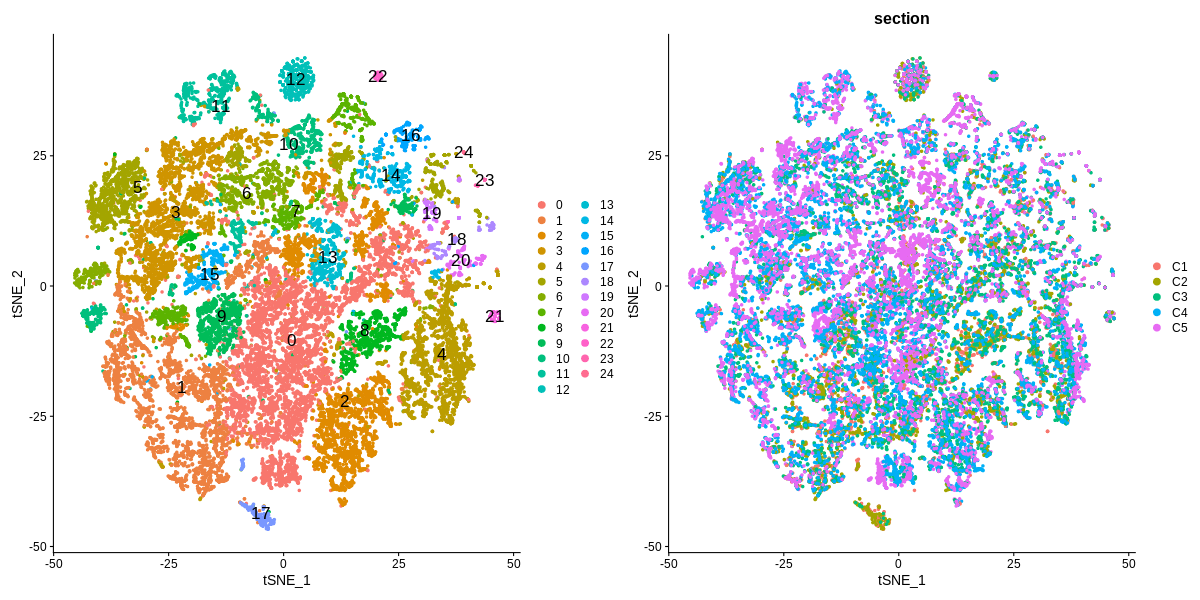

In [18]:
%%R -w 1200 -h 600
p1<-DimPlot(scRNA1, reduction = "tsne",label = T,label.size = 6,pt.size = 1)
p2<-DimPlot(scRNA1, reduction = "tsne",label = F,label.size = 6,pt.size = 1,group.by="section")
p=p1|p2
ggsave("allcell.cluster.3.pdf")
p

### 3) Plot: FeaturePlot showing the expression of vGlut2/vGat/Chat, regular scale vs log scale

Saving 13.9 x 4.17 in image


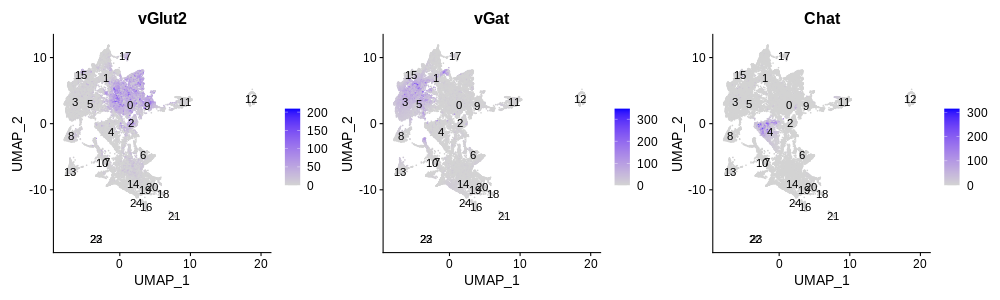

In [19]:
%%R -w 1000 -h 300
p=FeaturePlot(scRNA1, features = c("vGlut2","vGat",'Chat'),label=T,ncol=3)
ggsave("allcell.feature.1.pdf")
p

Saving 13.9 x 4.17 in image


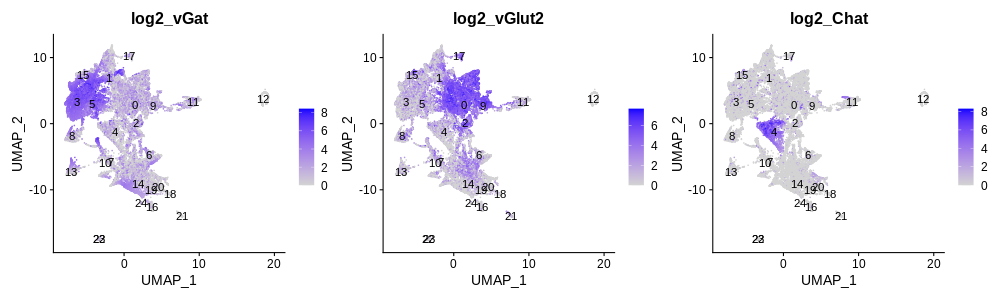

In [20]:
%%R -w 1000 -h 300
scRNA1$log2_vGat=log2(scRNA1["vGat",]$nCount_RNA+1)
scRNA1$log2_vGlut2=log2(scRNA1["vGlut2",]$nCount_RNA+1)
scRNA1$log2_Chat=log2(scRNA1["Chat",]$nCount_RNA+1)

p=FeaturePlot(scRNA1, features = c("log2_vGat",'log2_vGlut2','log2_Chat'),label=T,ncol=3)

ggsave("allcell.feature.2.pdf")
p

Saving 13.9 x 4.17 in image


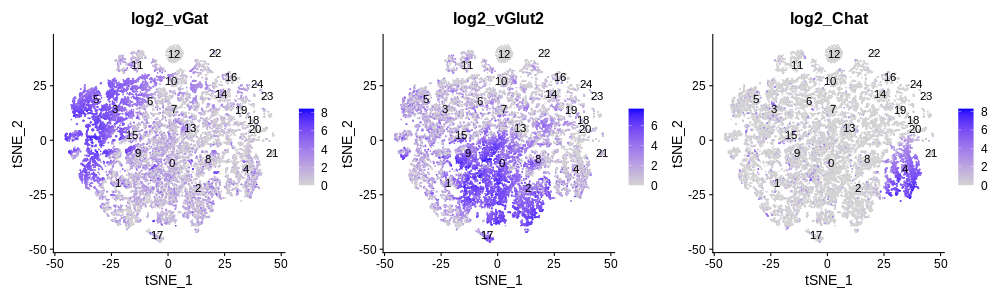

In [22]:
%%R -w 1000 -h 300

p=FeaturePlot(scRNA1, features = c("log2_vGat",'log2_vGlut2','log2_Chat'),label=T,ncol=3,reduction='tsne')
ggsave("allcell.feature.3.pdf")
p

## 2-set up filters for vGlu2+ neurons

### 1) Plot: Featurescatter of vGlut2/vGat, vGlut2/Chat, regular scale vs log scale

Saving 16.7 x 6.67 in image


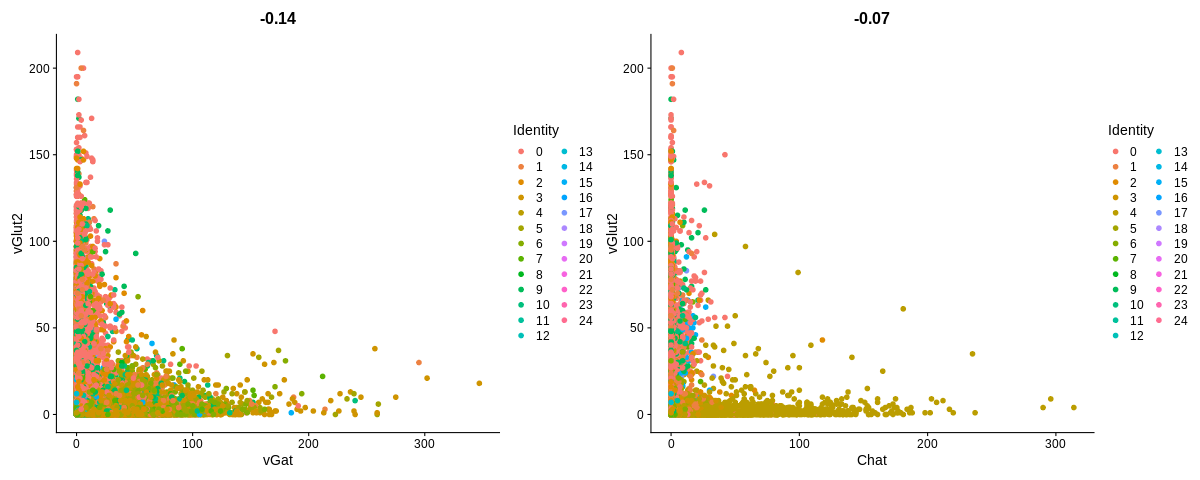

In [23]:
%%R -w 1200
p1<-FeatureScatter(object = scRNA1, feature1 = 'vGat', feature2 = 'vGlut2',pt.size=2,group.by="seurat_clusters")#+ 
p2<-FeatureScatter(object = scRNA1, feature1 = 'Chat', feature2 = 'vGlut2',pt.size=2,group.by="seurat_clusters")#+ 

    #geom_hline(yintercept=log2(50), linetype="dashed", color = "red", size=2)+
    #geom_vline(xintercept=log2(100), linetype="dashed", color = "red", size=2)
p=p1|p2

ggsave("filter.1.pdf")
p

Saving 16.7 x 6.67 in image


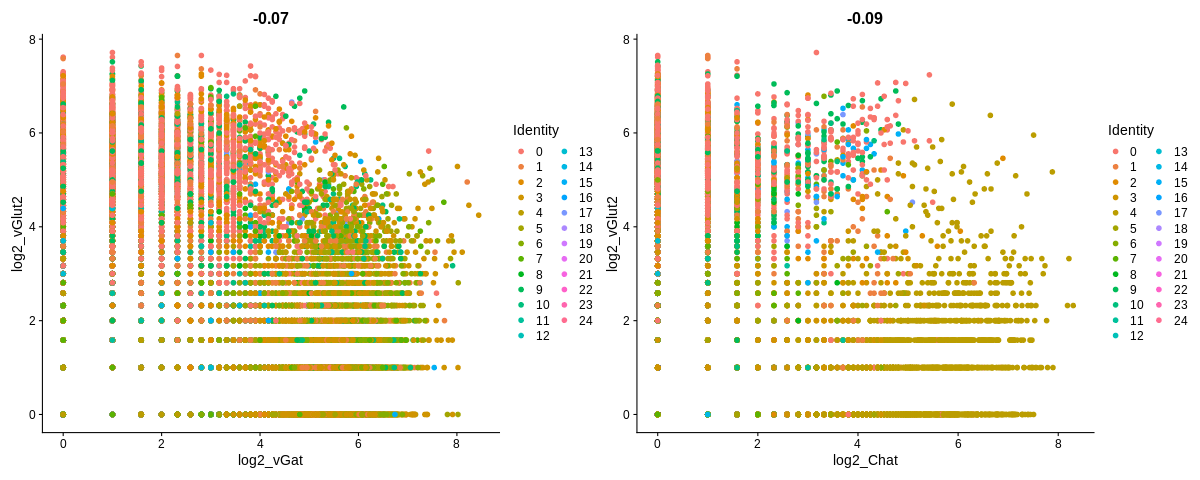

In [24]:
%%R -w 1200
p1<-FeatureScatter(object = scRNA1, feature1 = 'log2_vGat', feature2 = 'log2_vGlut2',pt.size=2,group.by="seurat_clusters")#+ 
p2<-FeatureScatter(object = scRNA1, feature1 = 'log2_Chat', feature2 = 'log2_vGlut2',pt.size=2,group.by="seurat_clusters")#+ 

    #geom_hline(yintercept=log2(50), linetype="dashed", color = "red", size=2)+
    #geom_vline(xintercept=log2(100), linetype="dashed", color = "red", size=2)
p=p1|p2

ggsave("filter.2.pdf")
p

### 2) plot: Vlnplot ot showing expression of vGat, vGlut2, Chat, regular scale vs log scale

Saving 16.7 x 4.17 in image


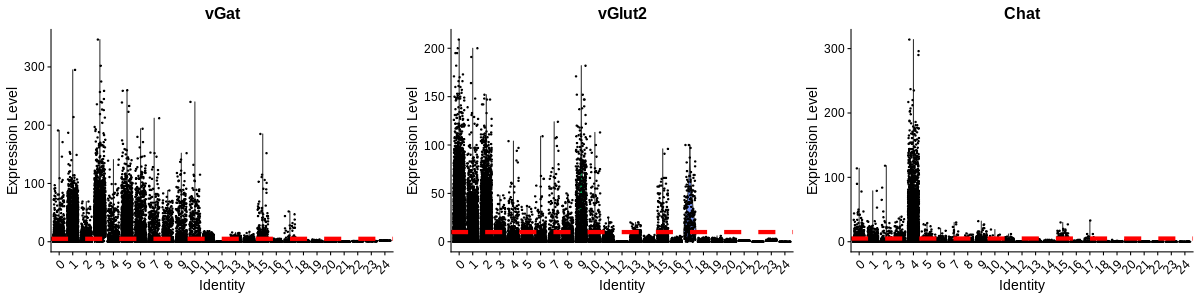

In [25]:
%%R -w 1200 -h 300

vglut2_threshold=10
vgat_threshold=5
Chat_threshold=5
plots<- VlnPlot(scRNA1, features = c("vGat",'vGlut2','Chat'),pt.size=0.5,log=F,combine=F)
plots[[1]]=plots[[1]]+ geom_hline(yintercept=vgat_threshold, linetype="dashed", color = "red", size=2)
plots[[2]]=plots[[2]]+ geom_hline(yintercept=vglut2_threshold, linetype="dashed", color = "red", size=2)
plots[[3]]=plots[[3]]+ geom_hline(yintercept=Chat_threshold, linetype="dashed", color = "red", size=2)

p=CombinePlots(plots = plots, legend = 'NULL', ncol = 3)

ggsave("filter.3.pdf")
p

Saving 16.7 x 4.17 in image


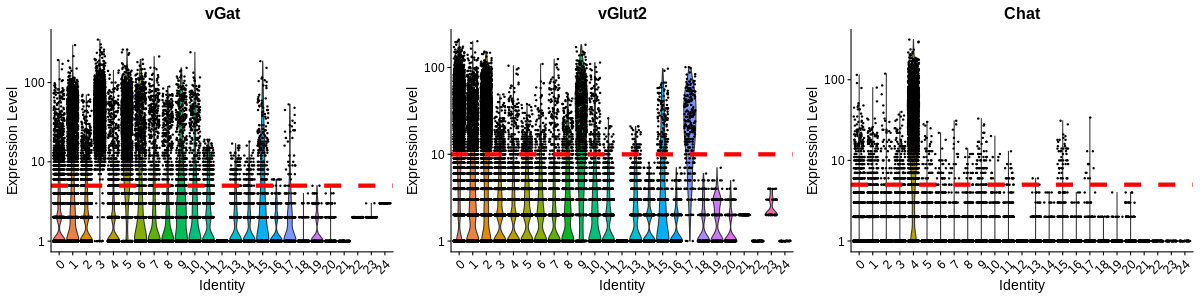

In [26]:
%%R -w 1200 -h 300

vglut2_threshold=10
vgat_threshold=5
Chat_threshold=5
plots<- VlnPlot(scRNA1, features = c("vGat",'vGlut2','Chat'),pt.size=0.5,combine=F,log=T)
plots[[1]]=plots[[1]]+ geom_hline(yintercept=vgat_threshold, linetype="dashed", color = "red", size=2)
plots[[2]]=plots[[2]]+ geom_hline(yintercept=vglut2_threshold, linetype="dashed", color = "red", size=2)
plots[[3]]=plots[[3]]+ geom_hline(yintercept=Chat_threshold, linetype="dashed", color = "red", size=2)

p=CombinePlots(plots = plots, legend = 'NULL', ncol = 3)


ggsave("filter.4.pdf")
p

## Threshold for excitatory neurons 

vGat<5: Chat<5: vGlut2>10

In [27]:
%%R
DefaultAssay(scRNA1)<-'RNA'

In [28]:
%%R
scRNA1$nCount_vGat=scRNA1['vGat',]$nCount_RNA
scRNA1$nCount_vGlut2=scRNA1['vGlut2',]$nCount_RNA
scRNA1$nCount_Chat=scRNA1['Chat',]$nCount_RNA

In [29]:
%%R
#scRNA1@meta.data=scRNA1@meta.data%>% 
#  mutate(Tag = case_when(nCount_vgat>vgat_threshold & nCount_vglut2>vglut2_threshold ~ "double positive",
#                         nCount_vgat>vgat_threshold & nCount_vglut2<=vglut2_threshold ~ "vGat+&vGlut2-",
#                         nCount_vgat<=vgat_threshold & nCount_vglut2>vglut2_threshold ~ "vGlut2+&vGat-",
#                         nCount_vgat<=vgat_threshold & nCount_vglut2<=vglut2_threshold ~ "double negtive",
#))

scRNA1$Tag=ifelse(scRNA1$nCount_vGlut2>10 & scRNA1$nCount_vGat<5 & scRNA1$nCount_Chat<5,'EXneuron','other')


Saving 16.7 x 8.33 in image


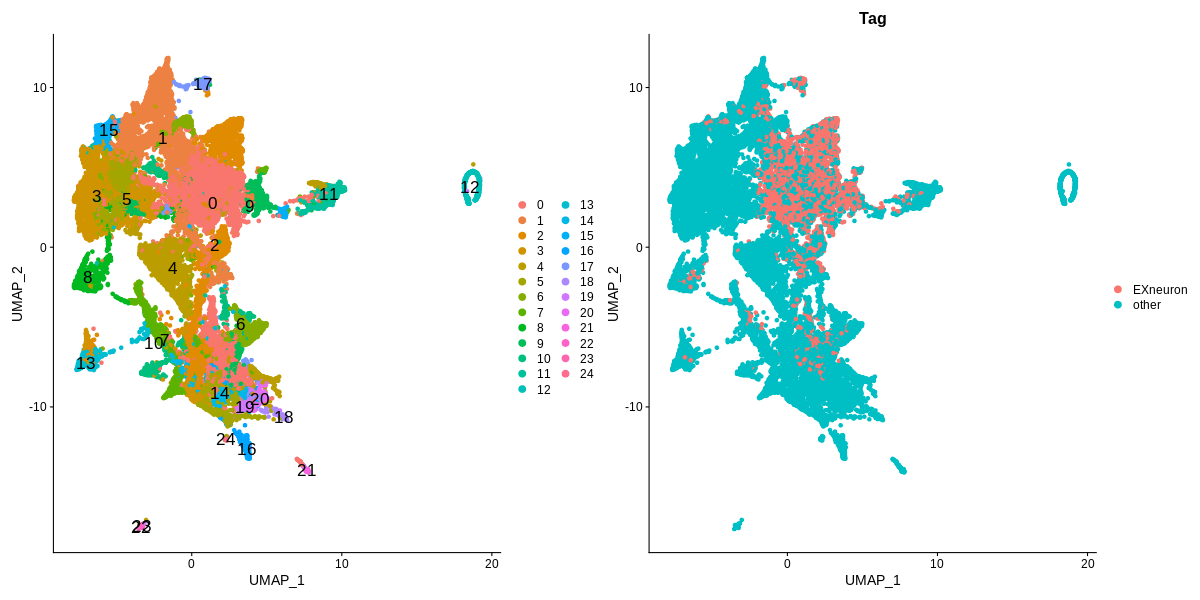

In [30]:
%%R -w 1200 -h 600
p1 <- DimPlot(scRNA1, reduction = "umap",label=T,label.size = 6,pt.size=1.5)
p2 <- DimPlot(scRNA1, reduction = "umap", group.by='Tag',pt.size=1.5)
p=p1 + p2


ggsave("Exneurons.1.pdf")
p

Saving 16.7 x 8.33 in image


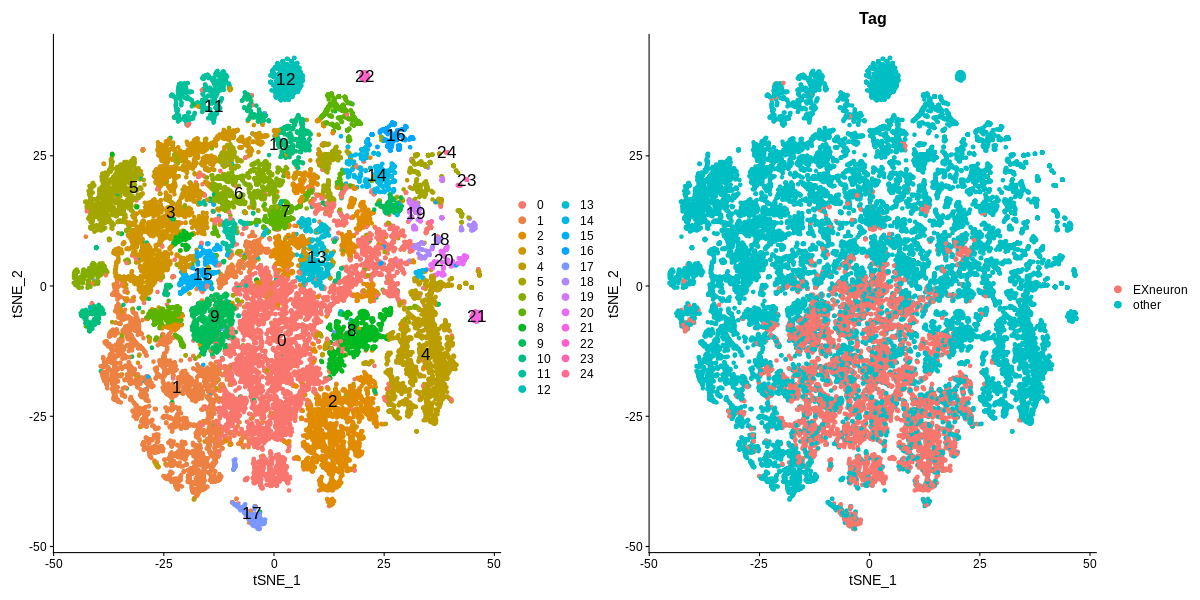

In [31]:
%%R -w 1200 -h 600
p1 <- DimPlot(scRNA1, reduction = "tsne",label=T,label.size = 6,pt.size=1.5)
p2 <- DimPlot(scRNA1, reduction = "tsne", group.by='Tag',pt.size=1.5)
p=p1 + p2

ggsave("Exneurons.2.pdf")
p

Saving 16.7 x 8.33 in image


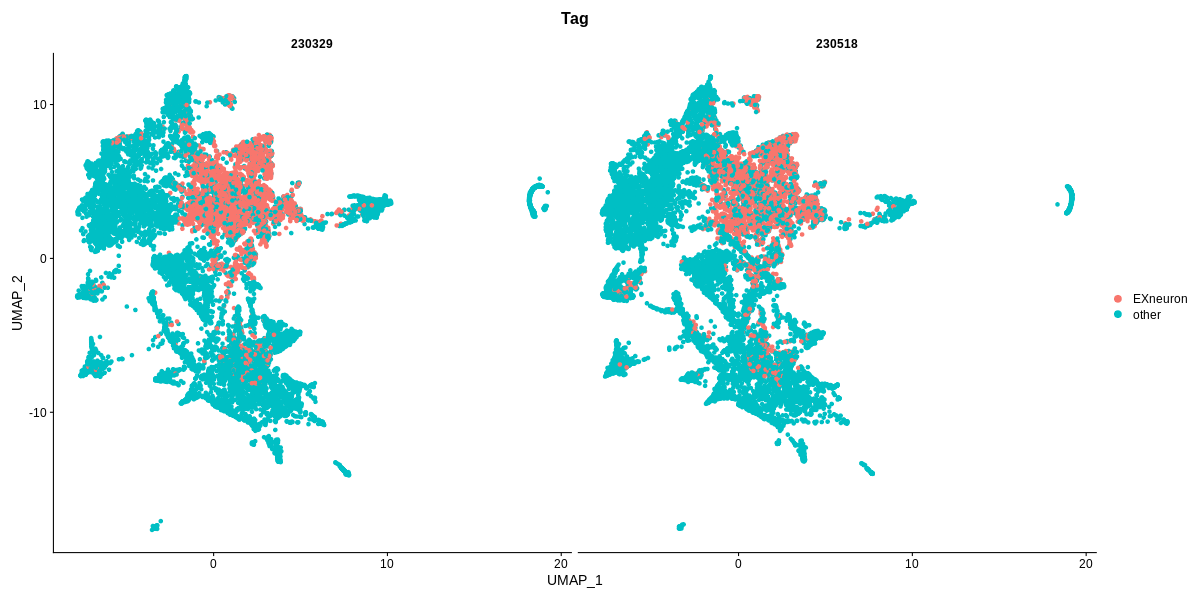

In [33]:
%%R -w 1200 -h 600
p2 <- DimPlot(scRNA1, reduction = "umap", group.by='Tag',pt.size=1.5,split.by='batch')
ggsave("Exneurons.3.pdf")

p2

Saving 16.7 x 8.33 in image


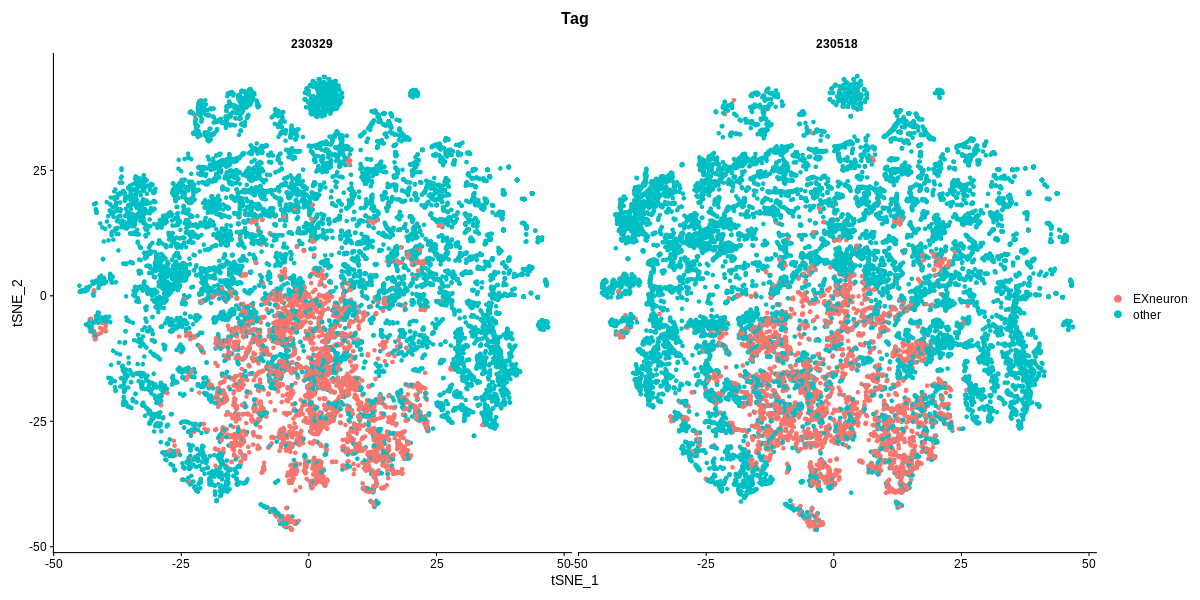

In [34]:
%%R -w 1200 -h 600
p2 <- DimPlot(scRNA1, reduction = "tsne", group.by='Tag',pt.size=1.5,split.by='batch')
ggsave("Exneurons.4.pdf")

p2

### 2) Table: No. per cluster, showing excitatory neurons; other neurons; excitatory in batch 1; excitatory in batch 2

batch:230329

In [35]:
%%R
tmp=subset(scRNA1,batch=="230329")
table(tmp@meta.data[,c("seurat_clusters",'Tag')])

               Tag
seurat_clusters EXneuron other
             0      2091  1642
             1       318  1031
             2       717   544
             3         1  1581
             4         5  1245
             5         0   749
             6        30   726
             7        16   454
             8        28   209
             9       198   269
             10       39   652
             11       14   615
             12        0   484
             13       12   298
             14        0   309
             15       48   349
             16        0   180
             17       90    47
             18        0   151
             19        0   150
             20        0   164
             21        0   125
             22        0    60
             23        0    36
             24        0    18


batch:230518

In [36]:
%%R
tmp=subset(scRNA1,batch=="230518")
table(tmp@meta.data[,c("seurat_clusters",'Tag')])

               Tag
seurat_clusters EXneuron other
             0      1615  1262
             1       458  2269
             2       813  1121
             3         0  1567
             4        26  1239
             5         1  1172
             6        14   518
             7        42   775
             8       107   787
             9       221   340
             10       28   289
             11       10   315
             12        0   260
             13       13   383
             14        0   279
             15       19    98
             16        0   170
             17       81    63
             18        0   112
             19        0    91
             20        0    67
             21        0    35
             22        0    52
             23        0    25
             24        0    28


### gene-cell matrix with extra info

Excitatory: [vGlut2>10, Gat<5. Chat<5]

Inhibitory: [vGlut2<5, VGat>10, Chat<5]

Cholinergic: [vGlut2<5,VGat<5, Chat>10]

No expression: [vGlut2<5, VGat<5,Chat<5]

Others: not belongs to above mentioned classes

In [37]:
%%R -o rawmatrix
rawmatrix=read.csv("gene_matrix.csv",row.names = 1)

In [38]:
%%R

scRNA1=AddMetaData(scRNA1,rawmatrix[,c(2,3)])

In [39]:
%%R
scRNA1$Tag=ifelse(scRNA1$nCount_vGlut2>10 & scRNA1$nCount_vGat<5 & scRNA1$nCount_Chat<5,'Excitatory',
                  ifelse(scRNA1$nCount_vGlut2<5 & scRNA1$nCount_vGat>10 & scRNA1$nCount_Chat<5,"Inhibitory",
                    ifelse(scRNA1$nCount_vGlut2<5 & scRNA1$nCount_vGat<5 & scRNA1$nCount_Chat>10,"Cholinergic",
                            ifelse(scRNA1$nCount_vGlut2<5 & scRNA1$nCount_vGat<5 & scRNA1$nCount_Chat<5,"NoExpression","others")
                          )
                        )
                 )


In [40]:
%%R
table(scRNA1@meta.data[,c("seurat_clusters",'Tag')])

               Tag
seurat_clusters Cholinergic Excitatory Inhibitory NoExpression others
             0           31       3706         78         1045   1750
             1           24        776        875         1320   1081
             2            6       1530         40          834    785
             3            0          1       2385           10    753
             4         1365         31         37          350    732
             5            0          1        891          326    704
             6            1         44        363          576    304
             7            3         58        152          856    218
             8            0        135        156          606    234
             9            1        419        101          125    382
             10           0         67        116          596    229
             11           0         24         45          679    206
             12           0          0          0          744      0
 

Saving 16.7 x 8.33 in image


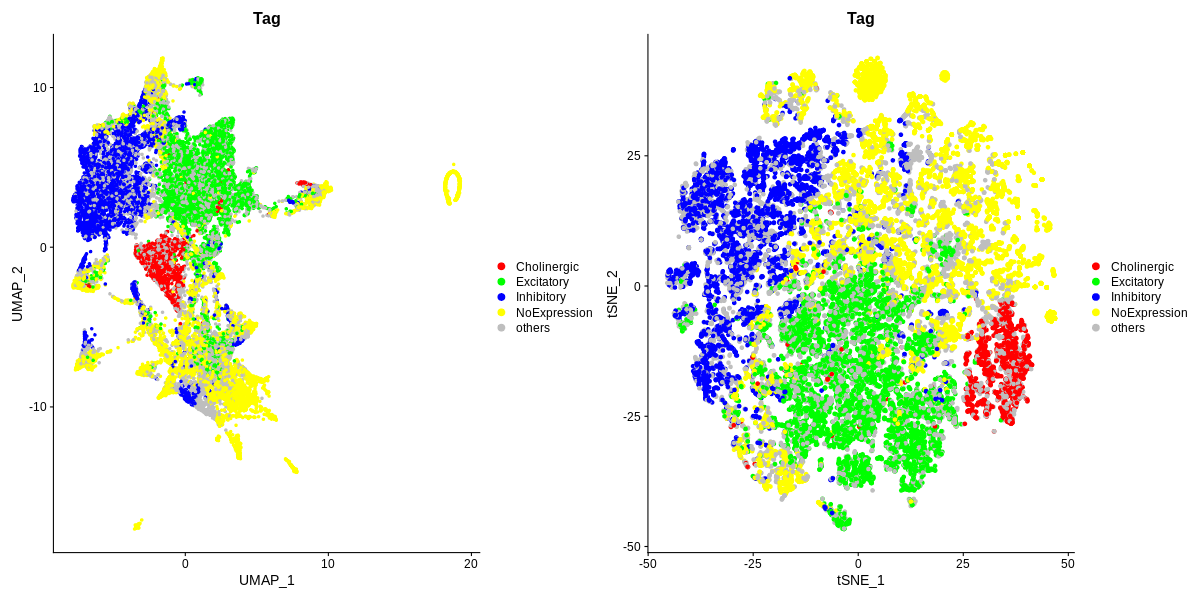

In [41]:
%%R -w 1200 -h 600
p1 <- DimPlot(scRNA1, reduction = "umap", group.by='Tag',pt.size=1,cols=c("red",'green','blue','yellow','grey'))
p2 <- DimPlot(scRNA1, reduction = "tsne", group.by='Tag',pt.size=1.5,cols=c("red",'green','blue','yellow','grey'))
p=p1|p2



gene-cell matrix :

In [43]:
%%R
out=t(as.data.frame(GetAssayData(scRNA1,slot='count')))
out=cbind(scRNA1@meta.data[rownames(out),c("seurat_clusters","Cell.Position.X",'Cell.Position.Y','Tag')],out)

write.csv(out,"gene-cell.matrix.csv",quote=F)


http://bioinfo.cibr.ac.cn/download/CIBR-BL-RNAScope-20230615/gene-cell.matrix.csv
